# Harjoitustyö: Johdanto datatieteeseen

Laura Mattila, 284850

Tässä notebookissa on harjoitustyön tekninen toteutus. Tarkemmin eri vaiheet ja niiden tarkoitukset on selitettynä eri vaiheita koskevissa välipalautuksissa, jotka löytyvät slackista. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict

# Haetaan data sivuilta ja luetaan se dataframeen
listings_url = 'http://data.insideairbnb.com/united-kingdom/scotland/edinburgh/2021-02-11/data/listings.csv.gz'

cols_listings = ['id',
                'number_of_reviews',
                'description',
                'property_type',
                'bedrooms',
                'price',
                'neighbourhood_cleansed',
                'minimum_nights',
                'maximum_nights',
                'reviews_per_month',
                'review_scores_rating',
                'review_scores_accuracy']

listings_df_orig = pd.read_csv(listings_url, usecols = cols_listings)
listings_df = listings_df_orig.copy()
  
calendar_url = 'http://data.insideairbnb.com/united-kingdom/scotland/edinburgh/2021-02-11/data/calendar.csv.gz'

cols_calendar = ['listing_id',
                 'date',
                 'available',
                 'adjusted_price']


calendar_df_orig = pd.read_csv(calendar_url, usecols = cols_calendar)
calendar_df = calendar_df_orig.copy()

In [2]:
# Yhdistetään calendar- sekä listings-dataframet
df_mer = pd.merge(listings_df, calendar_df, left_on = 'id', right_on = 'listing_id', how = 'left').drop('listing_id', axis=1)
df_mer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385718 entries, 0 to 2385717
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   description             object 
 2   neighbourhood_cleansed  object 
 3   property_type           object 
 4   bedrooms                float64
 5   price                   object 
 6   minimum_nights          int64  
 7   maximum_nights          int64  
 8   number_of_reviews       int64  
 9   review_scores_rating    float64
 10  review_scores_accuracy  float64
 11  reviews_per_month       float64
 12  date                    object 
 13  available               object 
 14  adjusted_price          object 
dtypes: float64(4), int64(4), object(7)
memory usage: 291.2+ MB


In [3]:
# Koska date on object-tyyppinen, vaihdetaan ne päivämääriksi
df_mer['date'] = pd.to_datetime(df_mer['date'])

In [4]:
df_mer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385718 entries, 0 to 2385717
Data columns (total 15 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      int64         
 1   description             object        
 2   neighbourhood_cleansed  object        
 3   property_type           object        
 4   bedrooms                float64       
 5   price                   object        
 6   minimum_nights          int64         
 7   maximum_nights          int64         
 8   number_of_reviews       int64         
 9   review_scores_rating    float64       
 10  review_scores_accuracy  float64       
 11  reviews_per_month       float64       
 12  date                    datetime64[ns]
 13  available               object        
 14  adjusted_price          object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(6)
memory usage: 291.2+ MB


In [5]:
# Muutetaan Nan-arvot nolliksi
df_mer = df_mer.fillna(0)

# Koska bedrooms on float, muutetaan se intiksi
df_mer['bedrooms'] = df_mer['bedrooms'].astype('int64')

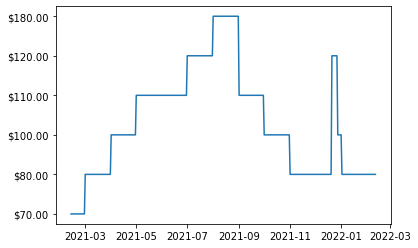

In [6]:
# Valitaan vain rivit, joissa id on sama tarkastelun vuoksi
df_one = df_mer.loc[df_mer['id']== 15420]

plt.plot(df_one.date, df_one.adjusted_price)

In [7]:
# Tehdään vuosilukujen muutos, sillä kuvaajassa näkyy vuosi 2022, joka ei ole vielä alkanut
df_one['date'] = df_one.apply(lambda x: x['date'].replace(2020) if x['date'].year == 2021 else x['date'], axis=1)
df_one['date'] = df_one.apply(lambda x: x['date'].replace(2021) if x['date'].year == 2022 else x['date'], axis=1)

<ipython-input-7-e66d4234075f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one['date'] = df_one.apply(lambda x: x['date'].replace(2020) if x['date'].year == 2021 else x['date'], axis=1)
<ipython-input-7-e66d4234075f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one['date'] = df_one.apply(lambda x: x['date'].replace(2021) if x['date'].year == 2022 else x['date'], axis=1)


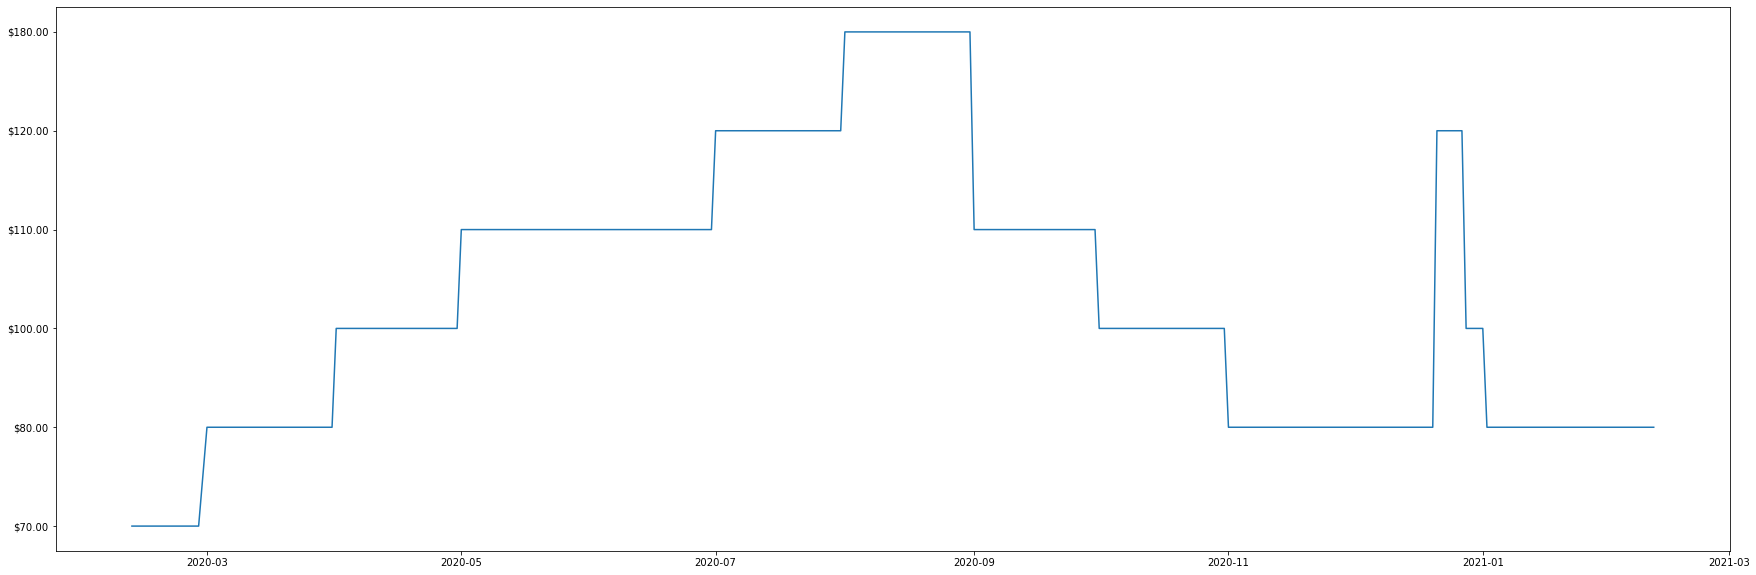

In [8]:
# Piirretään kuvaaja uudelleen ja huomataan, että kuvaaja on muuten sama, mutta vuodet on muuttuneet
# Muutos on siis sujunut suhteellisen oikein
plt.figure(figsize=(30,10))
plt.plot(df_one.date, df_one.adjusted_price)

In [9]:
# Tässä on vaihe, jolla muokattiin alun perin koko dataframen vuosiluvut oikeiksi, mutta se on pelkästään kommenttina,
# sillä vuosilukujen muokkaus osoittautui prosessin edetessä tarpeettomaksi.
# Syy on tarkemmin kuvattuna harjoitustyön vaiheiden dokumenteissa.

#df_mer['date'] = df_mer.apply(lambda x: x['date'].replace(2020) if x['date'].year == 2021 else x['date'], axis=1)
#df_mer['date'] = df_mer.apply(lambda x: x['date'].replace(2021) if x['date'].year == 2022 else x['date'], axis=1)
df_mer.head(10)

,id,description,neighbourhood_cleansed,property_type,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month,date,available,adjusted_price
0,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-12,f,$70.00
1,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-13,f,$70.00
2,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-14,f,$70.00
3,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-15,f,$70.00
4,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-16,f,$70.00
5,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-17,f,$70.00
6,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-18,f,$70.00
7,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-19,f,$70.00
8,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-20,f,$70.00
9,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,$70.00,3,30,340,99.0,10.0,2.77,2021-02-21,f,$70.00


In [10]:
# Poistetaan mahdolliset pilkut ja dollarimerkit hinnoista
df_mer.price = df_mer.price.replace(',','', regex=True)

df_mer.price = df_mer.price.str.strip('$')
df_mer.price = pd.to_numeric(df_mer.price)


In [11]:
df_mer.adjusted_price = df_mer.adjusted_price.replace(',','', regex=True)
df_mer.adjusted_price = df_mer.adjusted_price.str.strip('$')
df_mer.adjusted_price = pd.to_numeric(df_mer.adjusted_price)

In [12]:
df_mer.head()

,id,description,neighbourhood_cleansed,property_type,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month,date,available,adjusted_price
0,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-12,f,70.0
1,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-13,f,70.0
2,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-14,f,70.0
3,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-15,f,70.0
4,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-16,f,70.0


In [13]:
# Selvitetään onko price ja adjusted_price sarakkeet identtisiä, jotta voidaan selvittää eri sarakkeiden merkityksiä 
df_mer['price'].equals(df_mer['adjusted_price'])

False

In [14]:
# Lasketaan päivämäärille keskiarvohinta (adjusted price)
df_mean_price = df_mer.groupby('date')['adjusted_price'].mean().rename_axis('date').reset_index(name='mean_adjusted_price')

In [15]:
print(df_mean_price)

          date  mean_adjusted_price
0   2021-02-11            92.686275
1   2021-02-12           171.571429
2   2021-02-13           144.846847
3   2021-02-14           135.514308
4   2021-02-15           132.991737
..         ...                  ...
368 2022-02-14            50.000000
369 2022-02-15            50.000000
370 2022-02-16            50.000000
371 2022-02-17            50.000000
372 2022-02-18            65.000000

[373 rows x 2 columns]


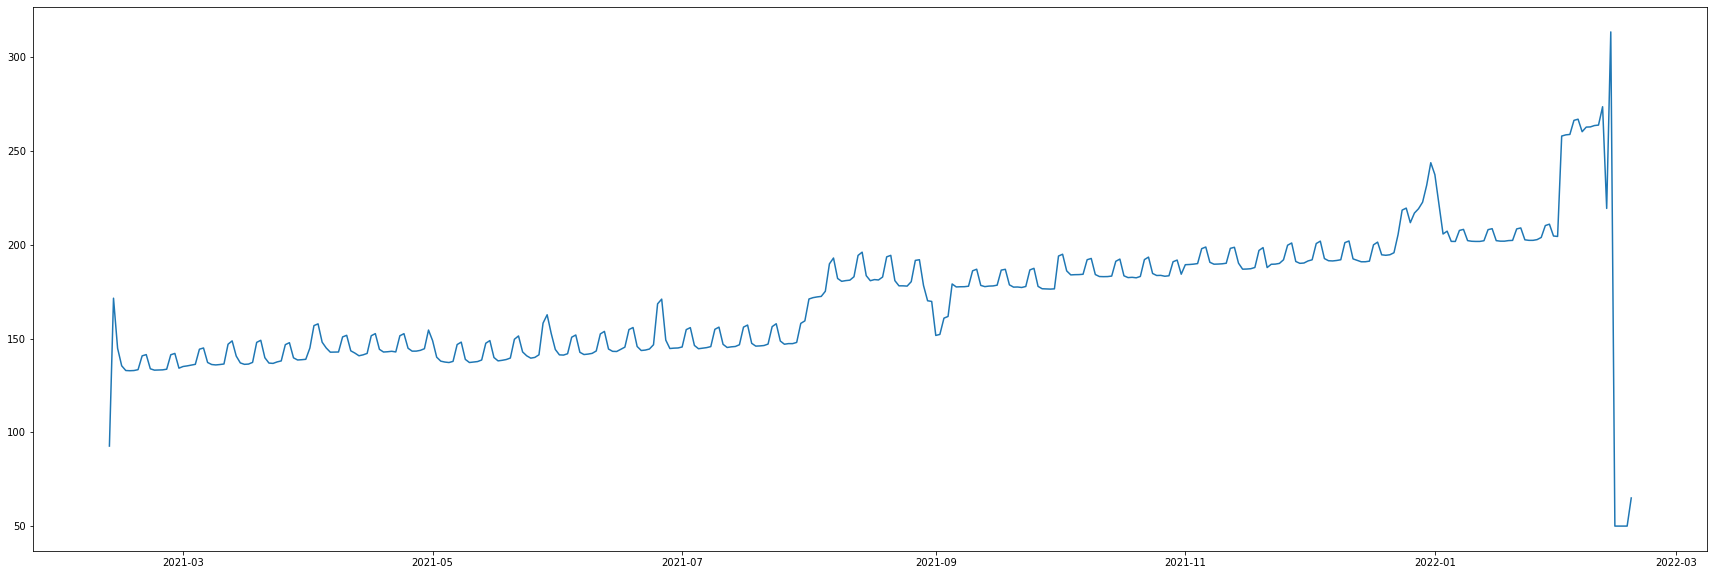

In [16]:
# Piirretään kuvaaja adjusted pricestä suhteessa päivämäärään
plt.figure(figsize=(30,10))
plt.plot(df_mean_price.date, df_mean_price.mean_adjusted_price)

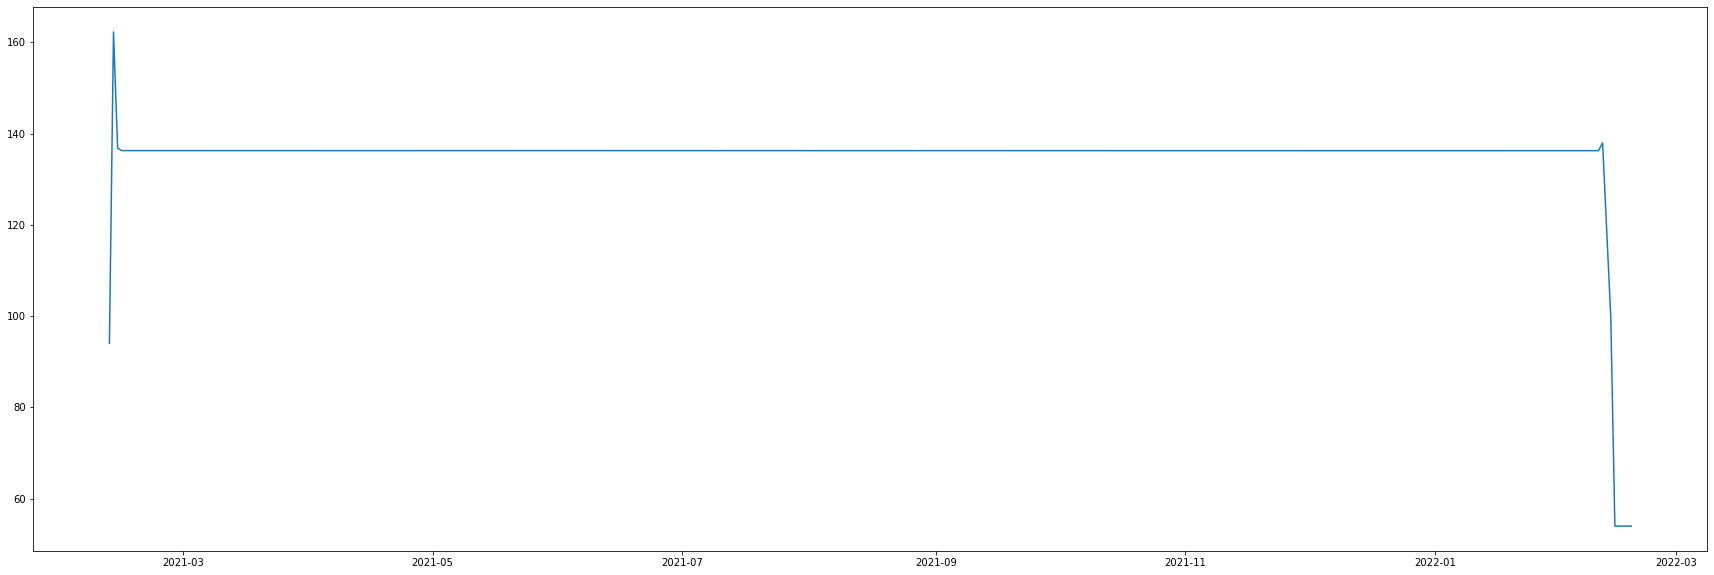

In [17]:
# Tehdään sama, mutta pelkälle pricelle
df_price = df_mer.groupby('date')['price'].mean().rename_axis('date').reset_index(name='mean_price')
plt.figure(figsize=(30,10))
plt.plot(df_price.date, df_price.mean_price)

<AxesSubplot:>

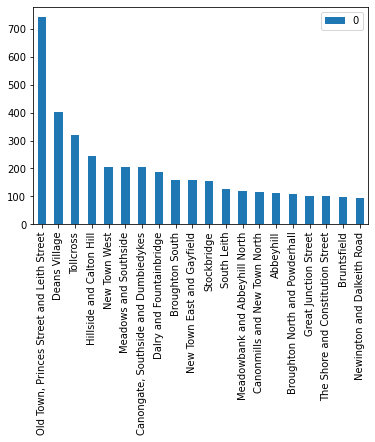

In [18]:
# Käytetään listings-dataframea, sillä yhdistellyssä datassa päivämäärät vääristelevät asuntojen määrää
nb_counts = Counter(listings_df.neighbourhood_cleansed)

# Otetaan 20 isointa kaupunginosaa ja tehdään niistä pylväsdiagrammi
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by = 0, ascending=False).head(20)
tdf.plot(kind='bar')

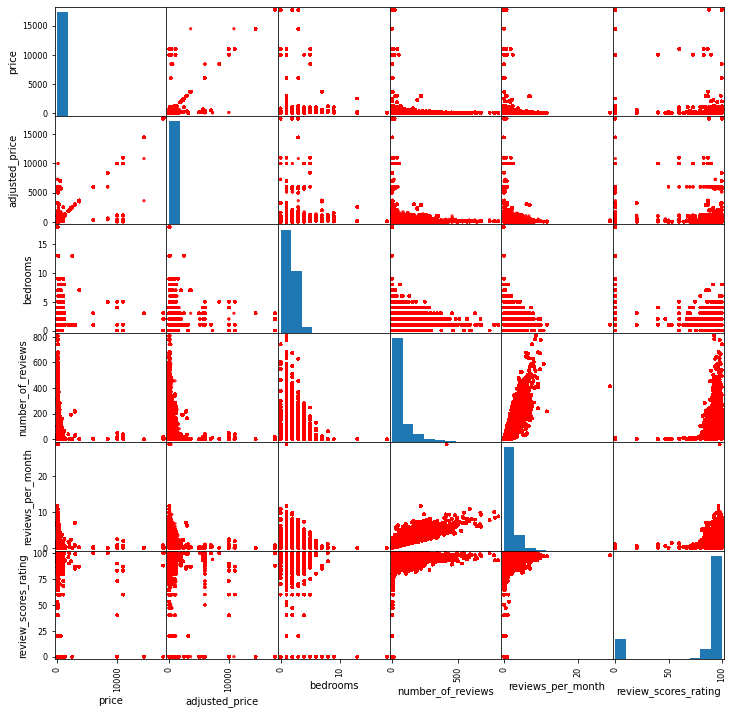

In [37]:
# Tarkastellaan eri sarakkeiden suhteita toisiinsa
# Vain adjusted price sekä price ovat selkeästi yhteydessä toisiinsa, mikä on loogista 
scattercols = ['price', 'adjusted_price', 'bedrooms', 'number_of_reviews', 'reviews_per_month', 'date', 'review_scores_rating']
axs = pd.plotting.scatter_matrix(df_mer[scattercols], figsize=(12, 12), c='red')

In [19]:
# Lasketaan arvostelujen kuukausittainen keskiarvo
mean_review_month = df_mer.groupby(df_mer['date'].dt.strftime('%B'),sort=False)['review_scores_rating'].mean()

Text(0, 0.5, 'Month')

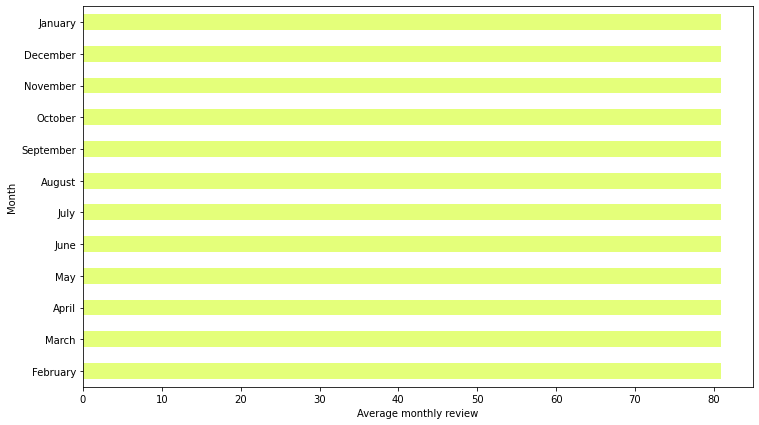

In [20]:
mean_review_month.plot(kind='barh', colormap = 'Wistia', figsize=(12,7))
plt.xlabel('Average monthly review')
plt.ylabel('Month')

In [21]:
# Tarkastellaan, onko arvosanojen keskiarvo joka kuukaudessa sama.
# Koska kaikki ovat samoja, ei kuvaaja tuo juurikaan arvoa.
print(mean_review_month)

date
February     80.862190
March        80.860159
April        80.860159
May          80.860159
June         80.860159
July         80.860159
August       80.860159
September    80.860159
October      80.860159
November     80.860159
December     80.860159
January      80.860159
Name: review_scores_rating, dtype: float64


Text(0, 0.5, 'Month')

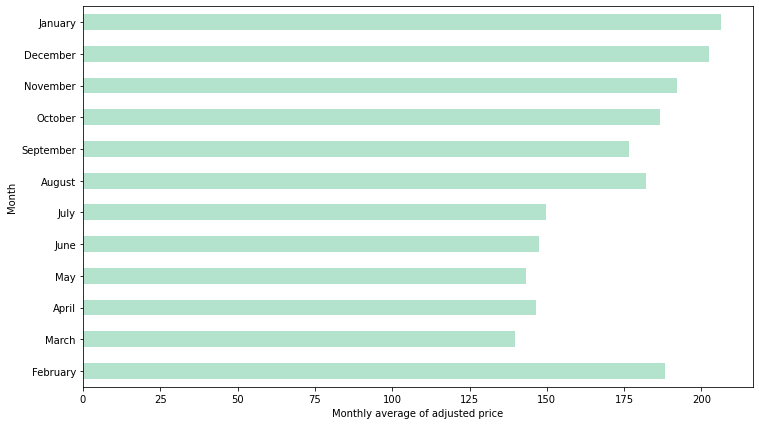

In [22]:
# Lasketaan ja piirretään myös kuukausittaiset keskiarvot adjusted pricelle
mean_price_month = df_mer.groupby(df_mer['date'].dt.strftime('%B'),sort=False)['adjusted_price'].mean()
mean_price_month.plot(kind='barh', colormap = 'Pastel2', figsize=(12,7))
plt.xlabel('Monthly average of adjusted price')
plt.ylabel('Month')

Text(0.5, 0, 'Month')

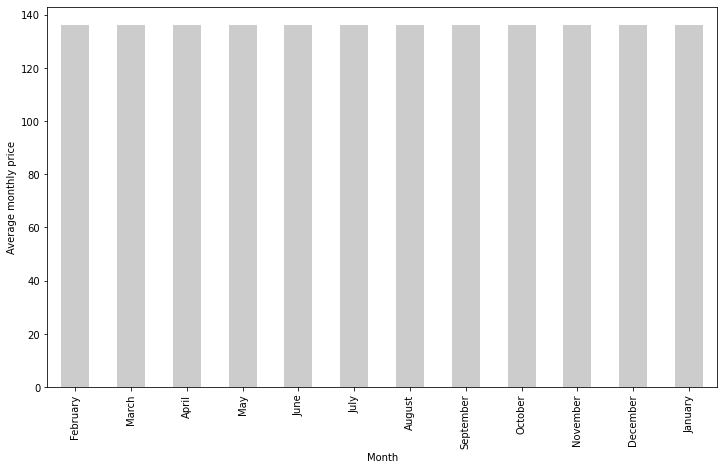

In [23]:
# Sama tehdään myös pelkälle pricelle, mutta myöskään tästä ei saada kovinkaan paljon arvoa, sillä keskiarvot ovat samat joka kuukausi
mean_price_month_2 = df_mer.groupby(df_mer['date'].dt.strftime('%B'),sort=False)['price'].mean()
mean_price_month_2.plot(kind='bar', colormap = 'Pastel2_r' ,figsize=(12,7))
plt.ylabel('Average monthly price')
plt.xlabel('Month')

In [24]:
# Muokataan kuukaudet numeroiksi, jotta lineaarisessa regressiossa voidaan ennustaa mm. hintoja kuukausien avulla
le = preprocessing.LabelEncoder()
arr = le.fit_transform(df_mer['date'].dt.month)

In [25]:
print(arr)

[1 1 1 ... 1 1 1]


In [26]:
# Epäloogisesti Helmikuu on 1, Tammikuu on 12
print(df_mer['date'].dt.month)        

0          2
1          2
2          2
3          2
4          2
          ..
2385713    2
2385714    2
2385715    2
2385716    2
2385717    2
Name: date, Length: 2385718, dtype: int64


In [27]:
df_mer.head(200)

,id,description,neighbourhood_cleansed,property_type,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month,date,available,adjusted_price
0,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-12,f,70.0
1,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-13,f,70.0
2,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-14,f,70.0
3,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-15,f,70.0
4,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-16,f,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-26,t,180.0
196,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-27,f,180.0
197,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-28,f,180.0
198,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-29,f,180.0


In [28]:
df_mer['month']=arr

In [29]:
# Tarkastetaan, että kuukausia kuvaava sarake tuli taulukkoon 
df_mer.head(200)

,id,description,neighbourhood_cleansed,property_type,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month,date,available,adjusted_price,month
0,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-12,f,70.0,1
1,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-13,f,70.0,1
2,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-14,f,70.0,1
3,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-15,f,70.0,1
4,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-02-16,f,70.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-26,t,180.0,7
196,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-27,f,180.0,7
197,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-28,f,180.0,7
198,15420,"Stunning, impeccably refurbished spacious grou...","Old Town, Princes Street and Leith Street",Entire apartment,1,70.0,3,30,340,99.0,10.0,2.77,2021-08-29,f,180.0,7


In [30]:
# Luodaan uusi dataframe lineaariseen regressioon, jotta voidaan tarkastella tiettyjä muuttujia
df_mer_new = df_mer[['adjusted_price','month','price']]
df_mer_new.head()

,adjusted_price,month,price
0,70.0,1,70.0
1,70.0,1,70.0
2,70.0,1,70.0
3,70.0,1,70.0
4,70.0,1,70.0


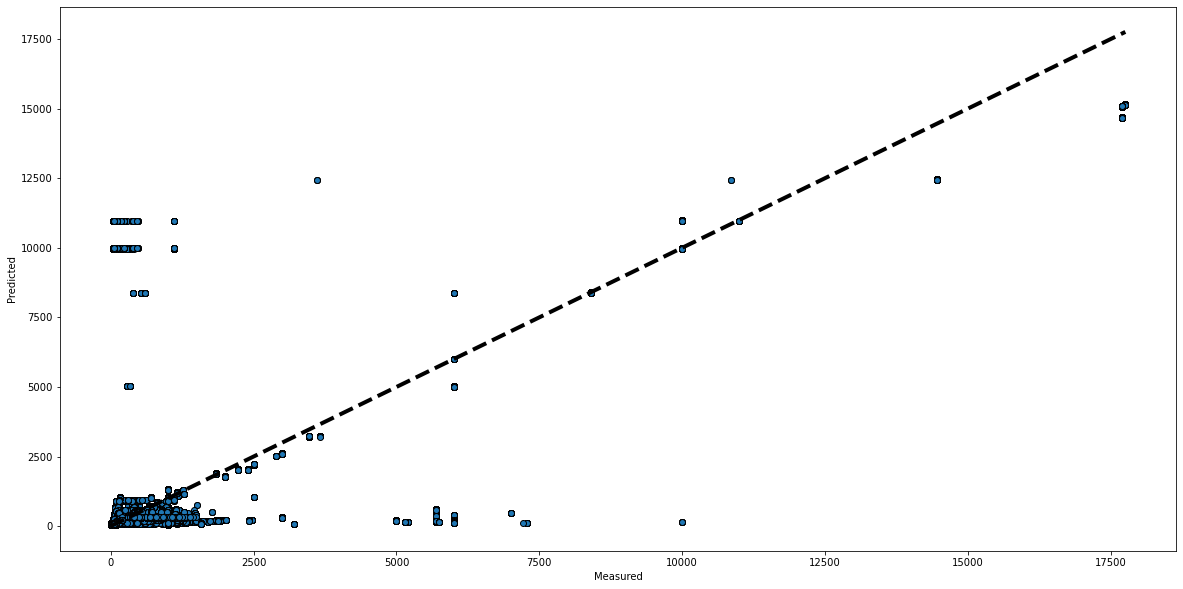

In [31]:
# Tehdään lineaarinen regressio ennustaen adjusted pricea pricen sekä kuukauden avulla
lr = linear_model.LinearRegression()
y = df_mer_new.adjusted_price
X = df_mer_new.drop(columns='adjusted_price')

predict = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [32]:
# Tarkastellaan eri muuttujien korrelaatiota 
print(df_mer_new.corr())

                adjusted_price         month         price
adjusted_price        1.000000  1.121005e-02  8.412838e-01
month                 0.011210  1.000000e+00 -1.578399e-07
price                 0.841284 -1.578399e-07  1.000000e+00


In [33]:
# Ennustetaan pricea kuukauden ja arvosteluiden määrän avulla
df_mer_new_2 = df_mer[['price','month','number_of_reviews']]

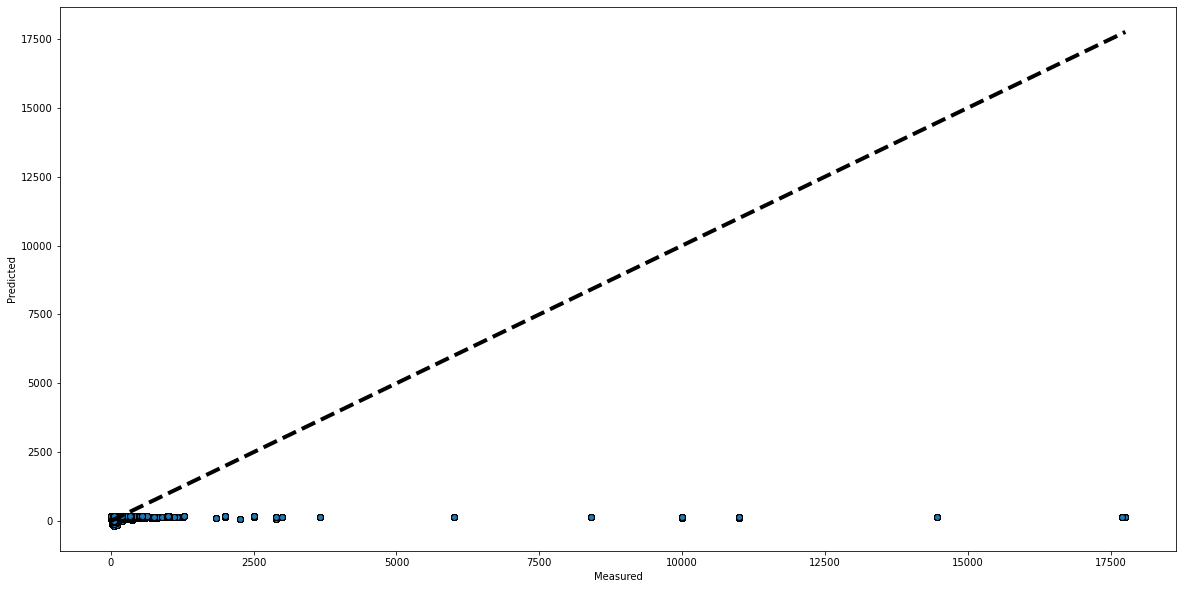

In [34]:
lr = linear_model.LinearRegression()
y = df_mer_new_2.price
X = df_mer_new_2.drop(columns='price')

predict = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [35]:
print(df_mer_new_2.corr())

                          price         month  number_of_reviews
price              1.000000e+00 -1.578399e-07          -0.047399
month             -1.578399e-07  1.000000e+00          -0.000007
number_of_reviews -4.739929e-02 -6.616585e-06           1.000000


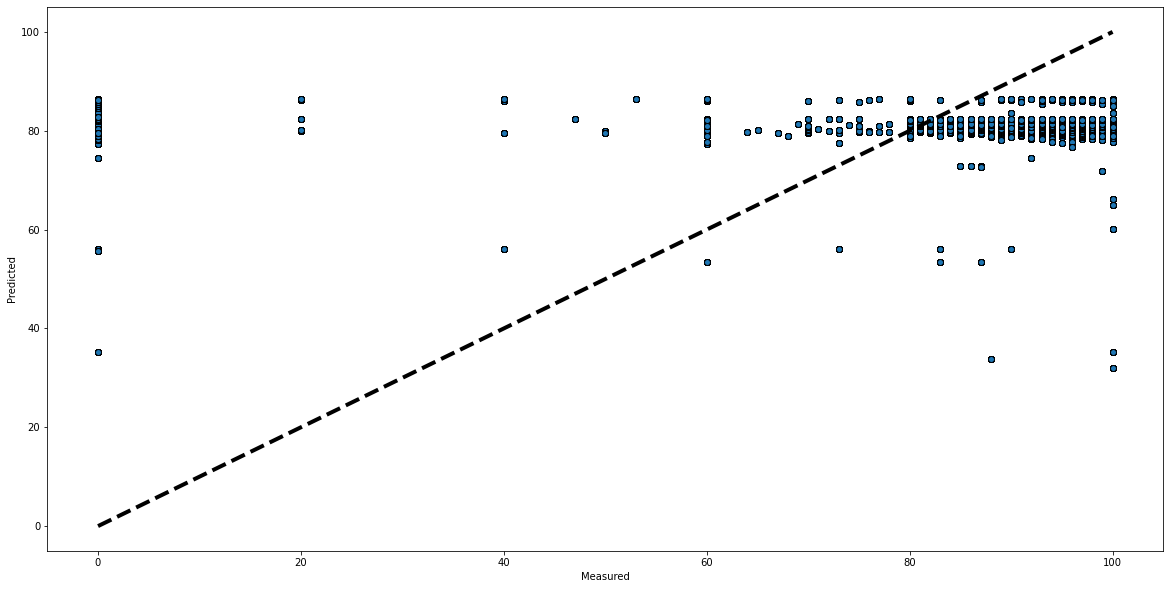

In [37]:
# Koitetaan voidaanko hinnan ja kuukauden avulla ennustaa arvosteluja
df_mer_new_3 = df_mer[['price','month','review_scores_rating']]
lr = linear_model.LinearRegression()
y = df_mer_new_3.review_scores_rating
X = df_mer_new_3.drop(columns='review_scores_rating')

predict = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [38]:
print(df_mer_new_3.corr())

                             price         month  review_scores_rating
price                 1.000000e+00 -1.578399e-07             -0.043642
month                -1.578399e-07  1.000000e+00             -0.000006
review_scores_rating -4.364172e-02 -5.894751e-06              1.000000
